In [49]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import efc_2dm as efc
import adefc_vortex.fresnel_2dm as fresnel
import adefc_vortex.fraunhofer_2dm as fraunhofer

Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
control_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)

dm1_flat = xp.rot90(xp.rot90( utils.load_fits('dm1_flat_command.fits') ))

[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]
[6.25625e-07 6.50000e-07 6.74375e-07]


/home/kianmilani/Projects/adefc-vortex/adefc_vortex


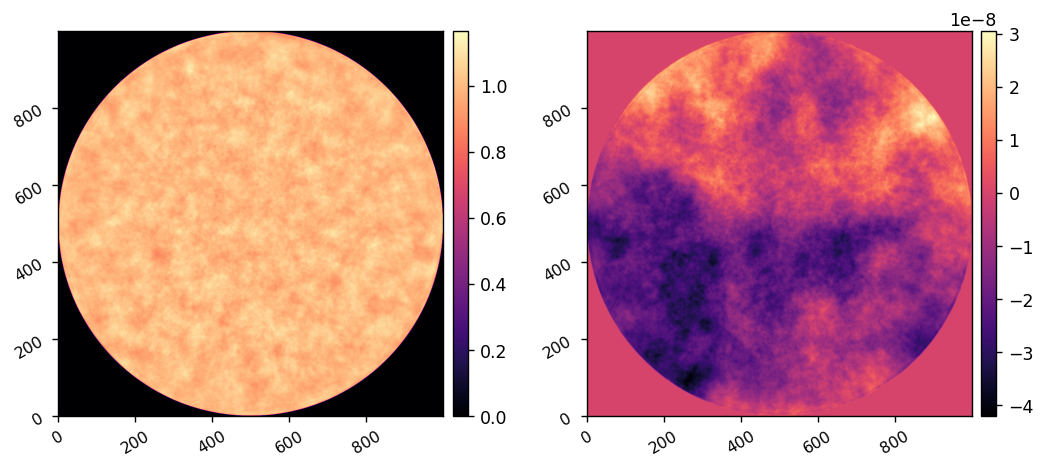

In [50]:
reload(fresnel)
I = fresnel.CORO(
    # dm1_ref=dm1_flat,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


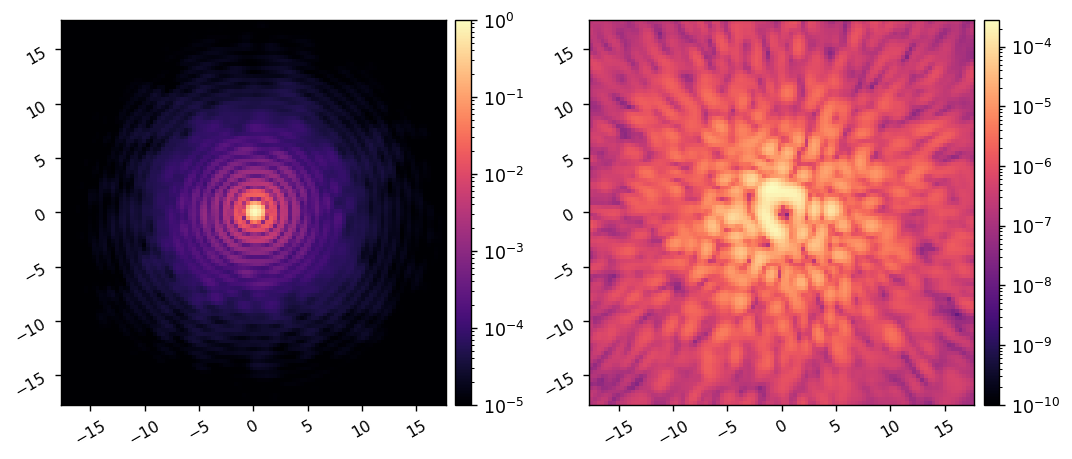

In [51]:
reload(fresnel)
I = fresnel.CORO(
        # dm1_ref=dm1_flat,
)
I.use_opds = True
I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


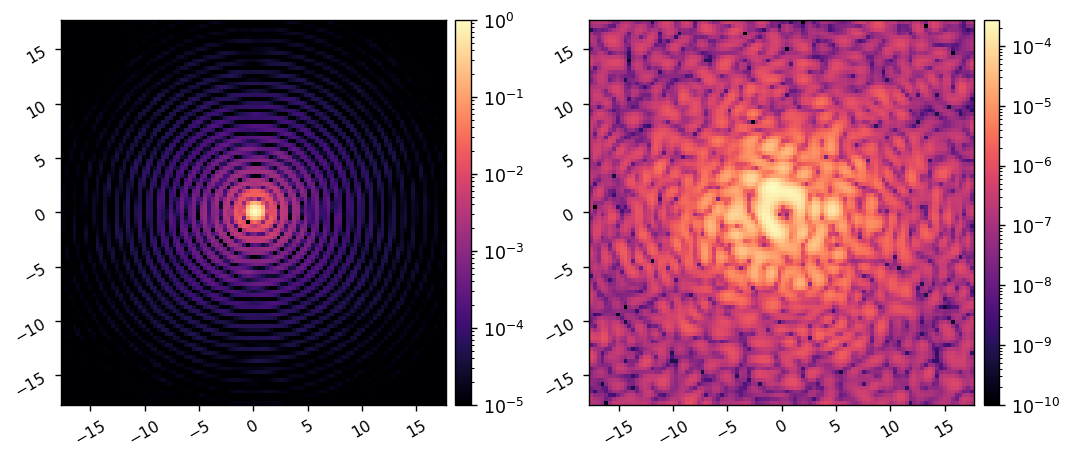

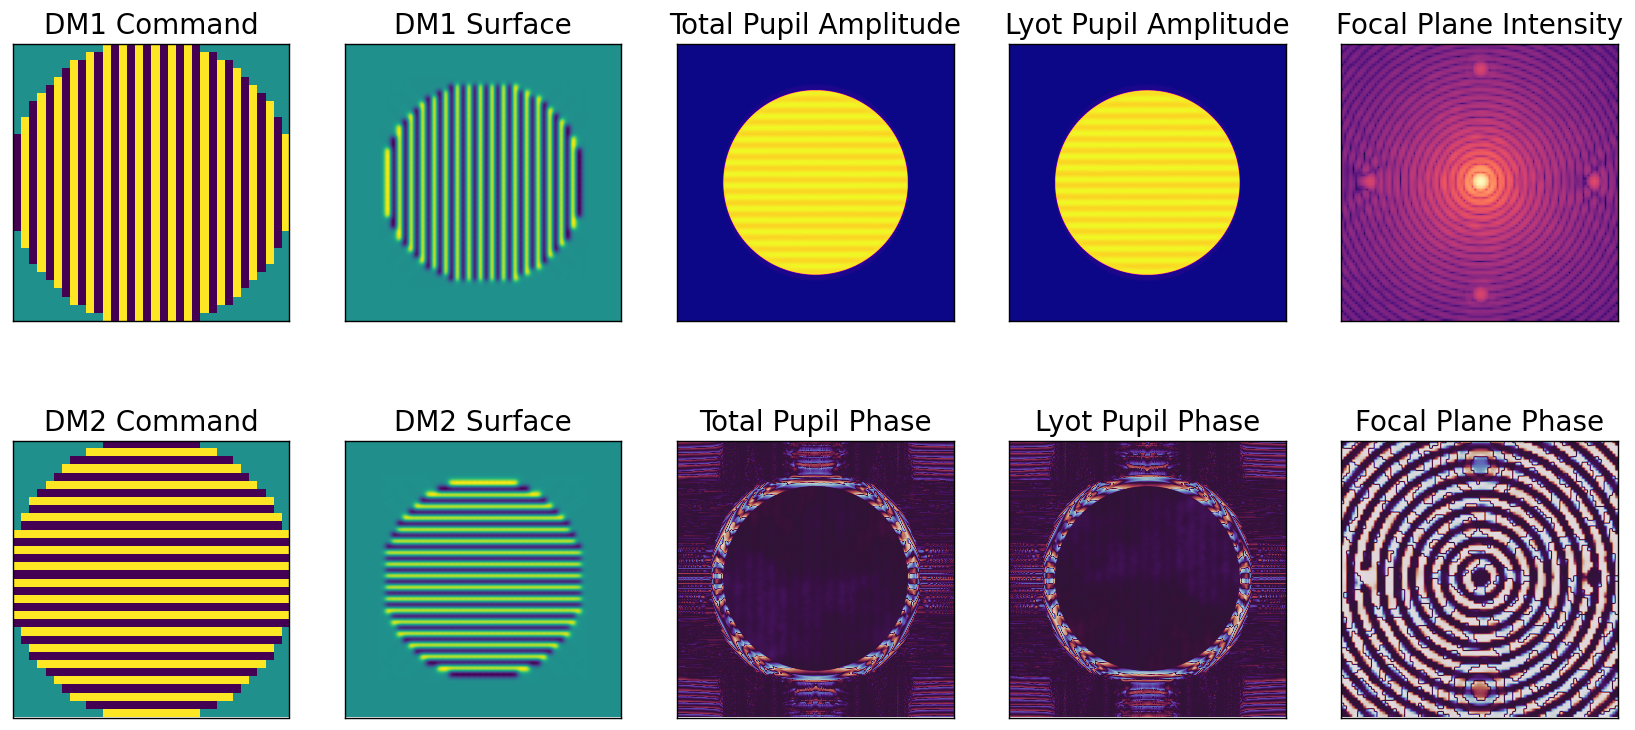

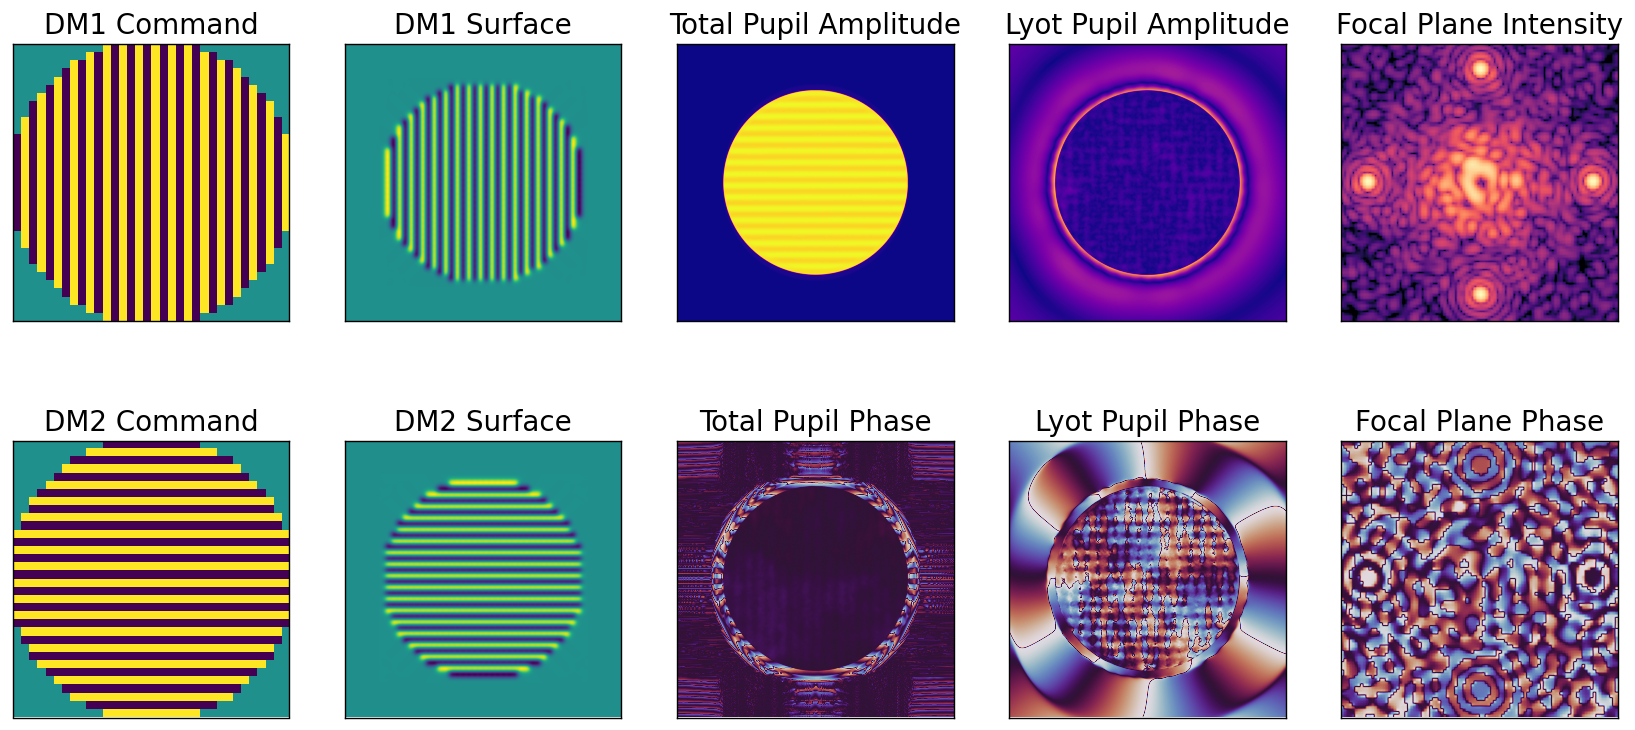

In [52]:
reload(fraunhofer)
M = fraunhofer.MODEL()
# M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=17, y_cpa=0)
dm2_command = -2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

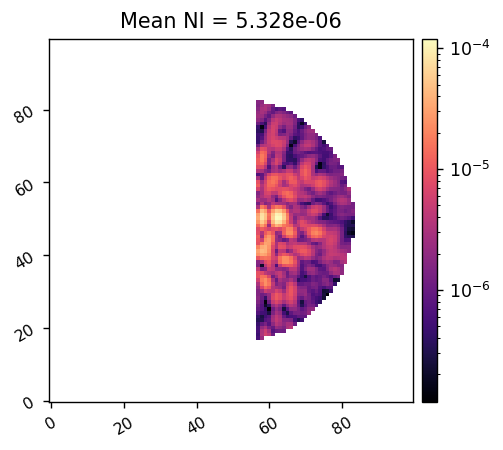

In [53]:
reload(utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
# control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


In [54]:
reload(efc)
jac = efc.compute_jacobian_bb(
    M, 
    control_mask, 
    control_waves, 
    amp=1e-9, 
    # current_acts=current_acts,
)

(7968, 1904)
(2656, 1904)
(2656, 1904)mode 1904/1904 in 202.792s
(2656, 1904)mode 1904/1904 in 203.180s


In [55]:
utils.save_pickle('jac_bb_half.pkl', jac)

Saved data to:  jac_bb_half.pkl


In [64]:
I.reset_dms()
data = {
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...


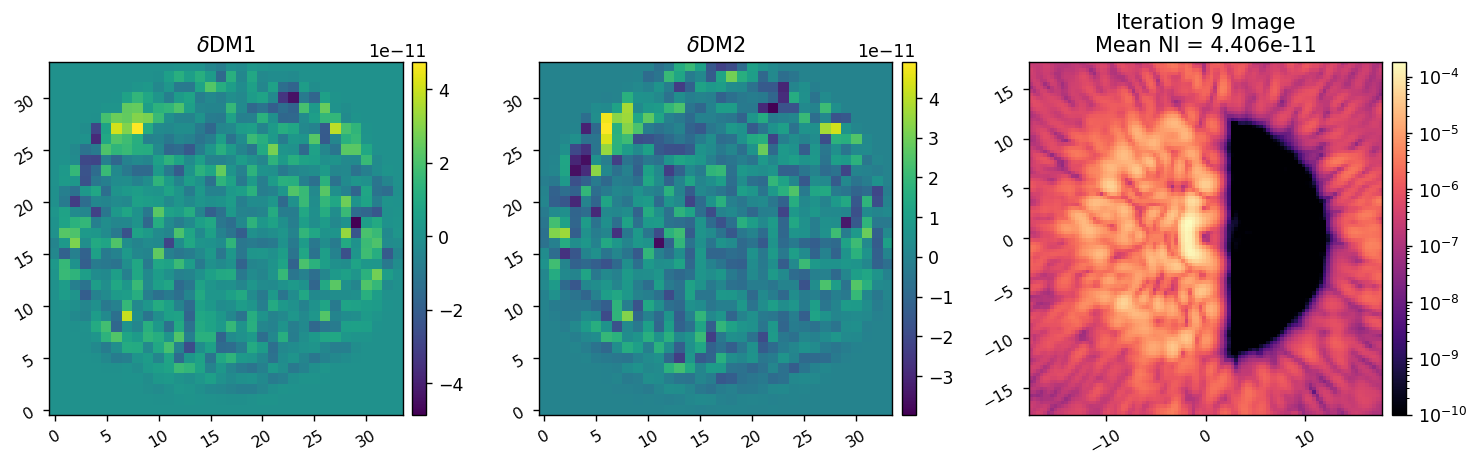

Computing E-field with model ...


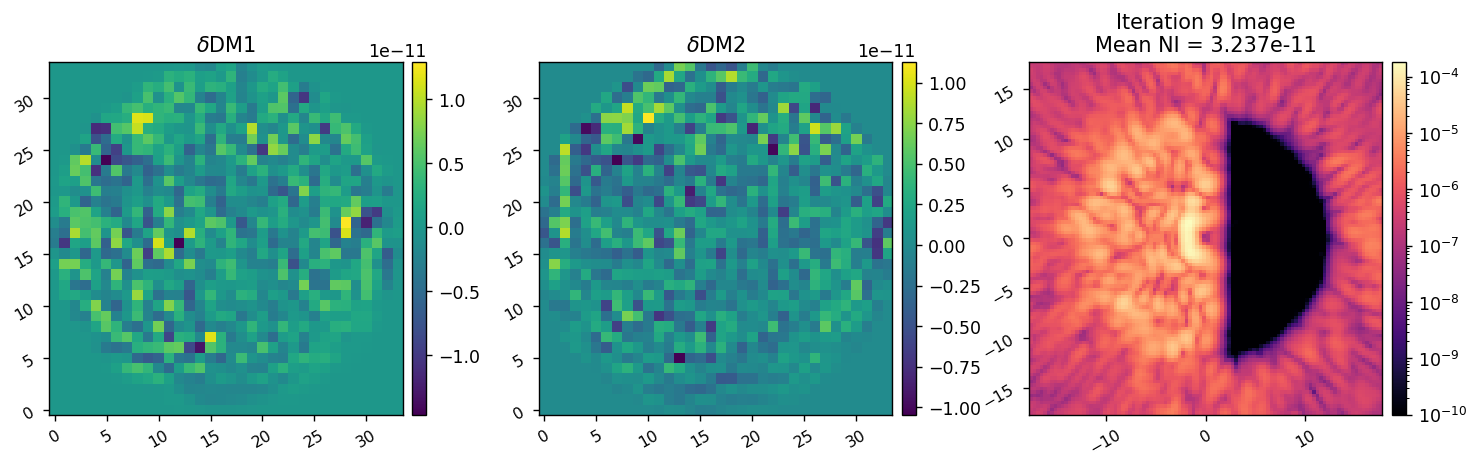

Computing E-field with model ...


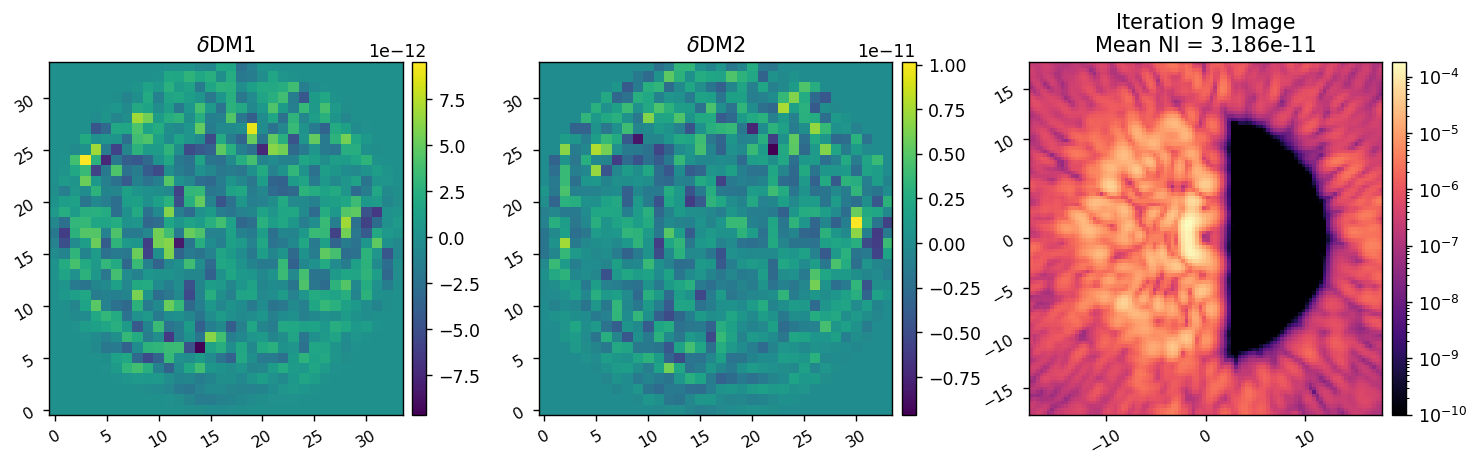

In [67]:
reload(fraunhofer)
reload(efc)

r_cond = -2.5
# r_cond = -3
# r_cond = -4
# r_cond = -5
# r_cond = -6

control_matrix = utils.beta_reg(jac, r_cond)

data = efc.run_bb(
    I, 
    control_matrix,
    control_mask, 
    control_waves,
    data,
    Nitr=3, 
    gain=1,
)

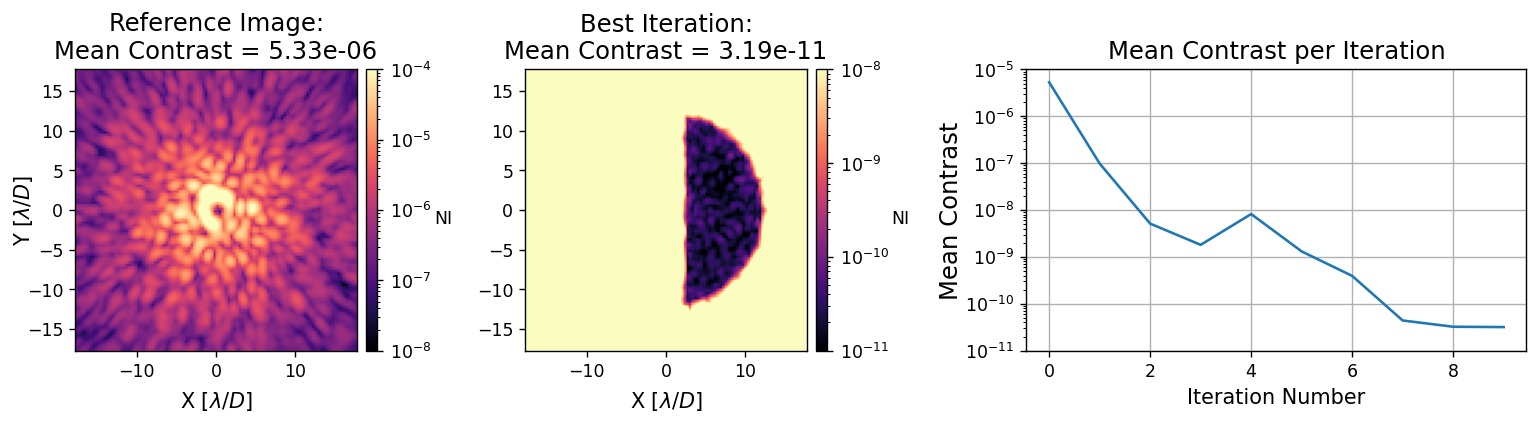

In [80]:
import adefc_vortex.imshows as imshows
reload(imshows)
imshows.plot_data(
    data, 
    im1vmin=1e-8, im1vmax=1e-4, 
    im2vmin=1e-11, im2vmax=1e-8,
    vmin=1e-11, vmax=1e-5,
)

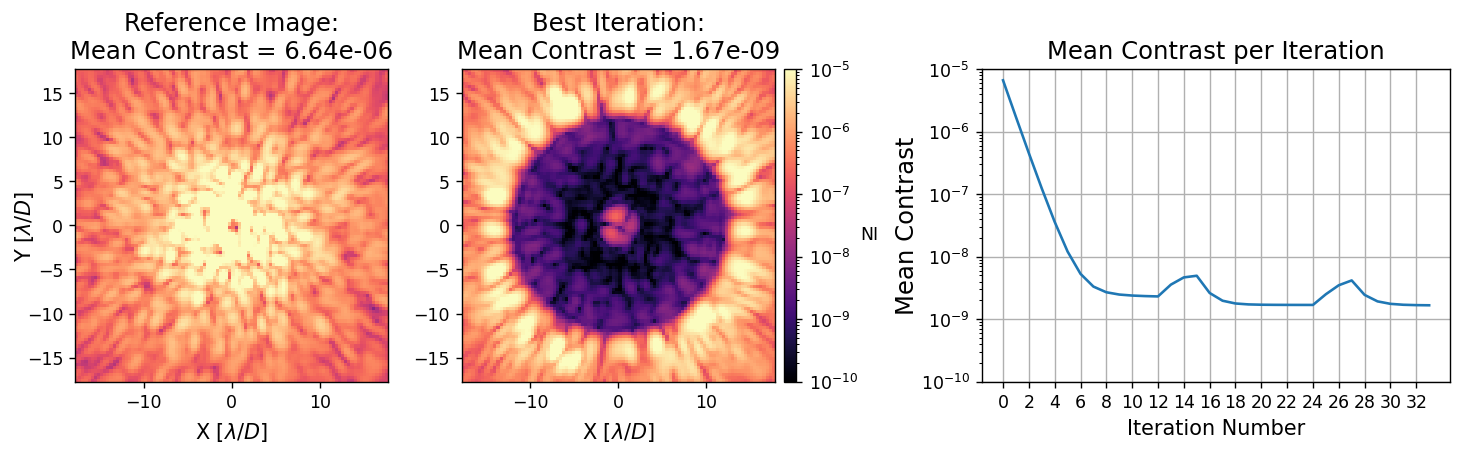

In [48]:
plot_data(data, imvmin=1e-10, imvmax=1e-5, vmin=1e-10, vmax=1e-5)

In [70]:
Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

I.bandpasses = bandpasses

[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]


In [71]:
bbim = I.snap()

2.793561891289966e-09


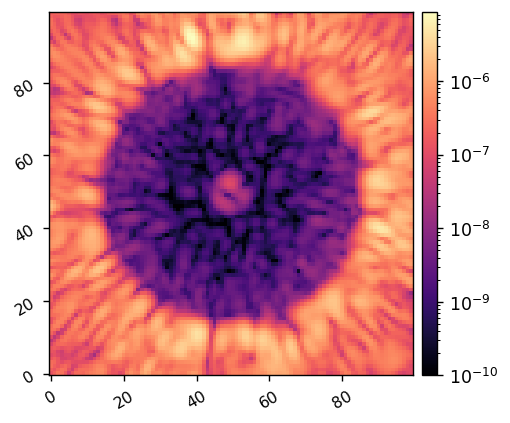

In [72]:
print(xp.mean(bbim[control_mask]))
imshow1(bbim, lognorm=True, vmin=1e-10)